In [ ]:
# Download the model weights

!wget -O downloaded_file.zip https://figshare.com/ndownloader/files/49563675?private_link=884c93d3ffb605036fcb
!unzip -n downloaded_file.zip -d .

In [36]:
import torch

import matplotlib.pyplot as plt
from functools import partial

from pfns import utils

In [2]:
from pfns.train import train, Losses
from pfns import encoders, bar_distribution

from pfns.priors import batched_discrete_bayes as bdb

In [4]:
hps = None
num_features = 1
max_dataset_size = 20


def train_a_pfn(
    get_batch_function,
    epochs=20,
    max_dataset_size=max_dataset_size,
    num_features=num_features,
    hps=hps,
    lr=0.001,
    batch_size=8,
    emsize=64,
    nlayers=4,
    n_classes=None,
    encoder_creator=None,
    **kwargs,
):
    if n_classes is None:
        # define a bar distribution (riemann distribution) criterion with 100 bars
        ys = get_batch_function(
            10000, 10, num_features, hyperparameters=hps
        ).target_y.to(utils.get_default_device())
        # we define our bar distribution adaptively with respect to the above sample of target ys from our prior
        criterion = bar_distribution.FullSupportBarDistribution(
            bar_distribution.get_bucket_limits(num_outputs=1000, ys=ys)
        )

    else:
        criterion = Losses.ce(n_classes)

    get_batch_method = partial(get_batch_function, hyperparameters=hps)

    # now train
    train_result = train(  # the prior is the key. It defines what we train on.
        get_batch_function,
        criterion=criterion,
        # define the transformer size
        emsize=emsize,
        nhead=emsize // 32,
        nhid=emsize * 4,
        nlayers=nlayers,
        # how to encode the x and y inputs to the transformer
        encoder_generator=encoder_creator or encoders.Linear,
        y_encoder_generator=encoders.Linear,
        # these are given to the prior, which needs to know how many features we have etc
        extra_prior_kwargs_dict={
            "num_features": num_features,
            "fuse_x_y": False,
            "hyperparameters": hps,
        },
        # change the number of epochs to put more compute into a training
        # an epoch length is defined by `steps_per_epoch`
        # the below means we do 10 epochs, with 100 batches per epoch and 4 datasets per batch
        # that means we look at 10*100*4 = 4000 datasets, typically we train on milllions of datasets.
        epochs=epochs,
        warmup_epochs=epochs // 4,
        steps_per_epoch=100,
        batch_size=batch_size,
        # the lr is what you want to tune! usually something in [.00005,.0001,.0003,.001] works best
        # the lr interacts heavily with `batch_size` (smaller `batch_size` -> smaller best `lr`)
        lr=lr,
        # seq_len defines the size of your datasets (including the test set)
        seq_len=max_dataset_size,
        # single_eval_pos_gen defines where to cut off between train and test set
        # a function that (randomly) returns lengths of the training set
        # the below definition, will just choose the size uniformly at random up to `max_dataset_size`
        single_eval_pos_gen=utils.get_uniform_single_eval_pos_sampler(max_dataset_size),
        **kwargs,
    )
    return train_result

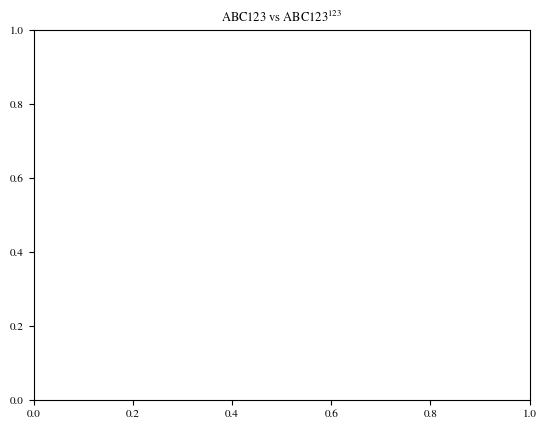

In [8]:
import matplotlib
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple

scatter_size = 8.0
line_size = 1.5

palette = sns.color_palette("muted")
sns.set_palette(palette)


matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")

matplotlib.rcParams["axes.titlesize"] = 9
matplotlib.rcParams["font.size"] = 8


@torch.no_grad()
def plot_data_ground_truth_and_model_predictions(ax, bae, model_or_models, x, y):
    test_x = torch.linspace(-1, 1, 100)[:, None]
    pred = bae.posterior_predictive_mean(x, y, test_x)

    if model_or_models is not None:
        if isinstance(model_or_models, (list, tuple)):
            models = model_or_models
        else:
            models = [model_or_models]

        model_preds = []
        for model in models:
            logits = model(x[:, None], y[:None], test_x[:, None])
            model_pred = model.criterion.mean(logits)
            model_preds += [model_pred]
    else:
        model_preds = []

    handles = []

    handles += [ax.plot(test_x, pred, linewidth=line_size)[0]]
    model_pred_handles = []
    for model_pred in model_preds:
        model_pred_handles += [ax.plot(test_x, model_pred, linewidth=line_size)[0]]
    handles += [tuple(model_pred_handles)]
    handles += [ax.scatter(x, y, s=scatter_size, c="black", zorder=2)]
    return handles


class OneDimPlotPanel:
    def __init__(
        self, bae, m, prior_seed, xy_in_dist_1, xy_in_dist_2, xy_generalization
    ):
        self.bae = bae
        self.m = m

        self.prior_seed = prior_seed
        self.xy_in_dist_1 = xy_in_dist_1
        self.xy_in_dist_2 = xy_in_dist_2
        self.xy_generalization = xy_generalization

    def prior_sample_plot(
        self,
        ax,
        num_examples=4,
        seed=None,
    ):
        if seed is not None:
            torch.manual_seed(seed)
        batch = self.bae.get_batch(num_examples, 100, 1)

        # indexes = list(range(batch.x.shape[1]))
        # if ylim is not None:
        #     within_limits_mostly = [((y >= ylim[0]) & (y<=ylim[1])).sum() > 95 for y in batch.y.transpose(0,1)]
        #     indexes = [i for i,b in enumerate(within_limits_mostly) if b] + indexes
        handles = []
        for i, batch_i in enumerate(range(batch.x.shape[1])):
            x, y = batch.x[:, batch_i].flatten(), batch.target_y[:, batch_i].flatten()
            handles += [ax.scatter(x, y, s=scatter_size, c=palette[i + 2])]
        # prior_df = pd.DataFrame([{'x' : x, 'y' : y, 'batch_index': str(i)} for i in range(batch.x.shape[1]) for x,y in zip(batch.x[:,i].flatten(), batch.target_y[:,i].flatten())])
        # sns.scatterplot(prior_df, x='x', y='y', hue='batch_index', ax=ax, legend=False, size=.1)
        return handles

    def __call__(
        self,
        ylim=None,
        num_prior_examples=4,
        as_separate_figs=False,
        no_ylim_for_sample=False,
    ):
        width = 7
        figsize = (width, width / 4.5)
        if as_separate_figs:
            subfigsize = (figsize[0] / 4, figsize[1])
            ax_list = []
            figs = []

            for i in range(4):
                fig, ax = plt.subplots(1, 1, figsize=subfigsize)
                ax_list.append(ax)
                figs.append(fig)
        else:
            fig, ax_list = plt.subplots(1, 4, figsize=figsize, dpi=400)
            figs = [fig]

        ax_prior, ax_in_dist_1, ax_in_dist_2, ax_generalization = ax_list

        ax_prior.set_title("Prior Samples")
        ax_in_dist_1.set_title("Predictions on likely data")
        ax_in_dist_2.set_title("Predictions on likely data")
        ax_generalization.set_title("Generalization")

        scatter_handles = self.prior_sample_plot(
            ax_prior, seed=self.prior_seed, num_examples=num_prior_examples
        )

        for ax, (x, y) in [
            (ax_in_dist_1, self.xy_in_dist_1),
            (ax_in_dist_2, self.xy_in_dist_2),
            (ax_generalization, self.xy_generalization),
        ]:
            line_plot_handles = plot_data_ground_truth_and_model_predictions(
                ax, self.bae, self.m, x, y
            )

        handles = [tuple(scatter_handles), *line_plot_handles]

        legend_reordering = [0, 3, 1, 2]

        # tuples of handles like (p1, p3)).
        fig.legend(
            [handles[i] for i in legend_reordering],
            [
                [
                    "Prior Samples",
                    "Posterior Ground Truth",
                    "NN Posterior Approx.",
                    "In-Context Examples",
                ][i]
                for i in legend_reordering
            ],
            handler_map={tuple: HandlerTuple(ndivide=None)},
            bbox_to_anchor=(0.5, 0.0),
            ncols=4,
            loc="upper center",
        )

        for i, ax in enumerate(ax_list):
            ax.set_xlim(-1.05, 1.05)
            if ylim is not None and (i > 0 or not no_ylim_for_sample):
                ax.set_ylim(ylim)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            if False:  # code to add x/y label and add arrows to axes
                # Set x-label at the end of the x-axis
                ax.set_xlabel("x", loc="left")

                # Set y-label at the top of the y-axis
                ax.set_ylabel("y", loc="bottom")

                # Optionally, you can fine-tune the position
                ax.xaxis.set_label_coords(1.05, -0.025)  # Adjust these values as needed
                ax.yaxis.set_label_coords(-0.025, 1.05)

                ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False, markersize=3)
                ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False, markersize=3)

        for ax in ax_list[2 if no_ylim_for_sample else 1 :]:
            ax.set_yticks([])
            ax.set_ylabel("")
            ax.spines["left"].set_visible(False)

        plt.tight_layout()

        return figs


None

## Sine And Line Combine

In [10]:
amp = 0.2
freq = 3 * torch.pi

slopes, y_offsets = torch.meshgrid(
    torch.linspace(-1, 1, 101), torch.linspace(-1, 1, 101)
)

bae = bdb.DiscreteBayes(
    [
        bdb.Sinus(
            torch.ones(101),
            y_offsets=torch.linspace(0, 1, 101),
            x_offsets=0.0,
            amplitudes=amp,
            frequencies=freq,
        ),
        bdb.Sinus(
            torch.ones(slopes.numel()),
            slopes=slopes.flatten(),
            y_offsets=y_offsets.flatten(),
        ),
    ]
)

x = torch.linspace(-1, 1, 10)[:, None]
y = bdb.Sinus(
    torch.tensor([1.0]), amplitudes=amp, frequencies=freq, slopes=0.23
).mean_y(x)
test_x = torch.linspace(-1, 1, 100)[:, None]
pred = bae.posterior_predictive_mean(x, y, test_x)

print("density:", bae.compute_log_posterior(x, y)[-1].exp())

/home/muellesa/miniconda3/envs/prior-fitting-24-t2.1/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


cpu cpu cpu
cpu cpu cpu
density: tensor(0.0006)


In [57]:
# Our HP search:
# sine_and_line_sin_yoffset_fixed =  [train_a_pfn(bae.get_batch, lr=lr, batch_size=batch_size, nlayers=nlayers, epochs=epochs,emsize=emsize,max_dataset_size=max_dataset_size)
#      for nlayers in [4,8] for batch_size in [32,64] for lr in [.0001,.0003,.001]
#      for emsize in [128,256,512] for epochs in [100,200,400] for max_dataset_size in [20,100]
#     ]
# )

best_sine_and_line_models = torch.load(
    "models_diff/sine_and_line_sin_yoffset_fixed_best_8_models.pt"
)

/tmp/ipykernel_2743969/484053737.py:76: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles += [ax.scatter(x,y,s=scatter_size,c=palette[i+2])]


cpu cpu cpu
cpu cpu cpu
cpu cpu cpu


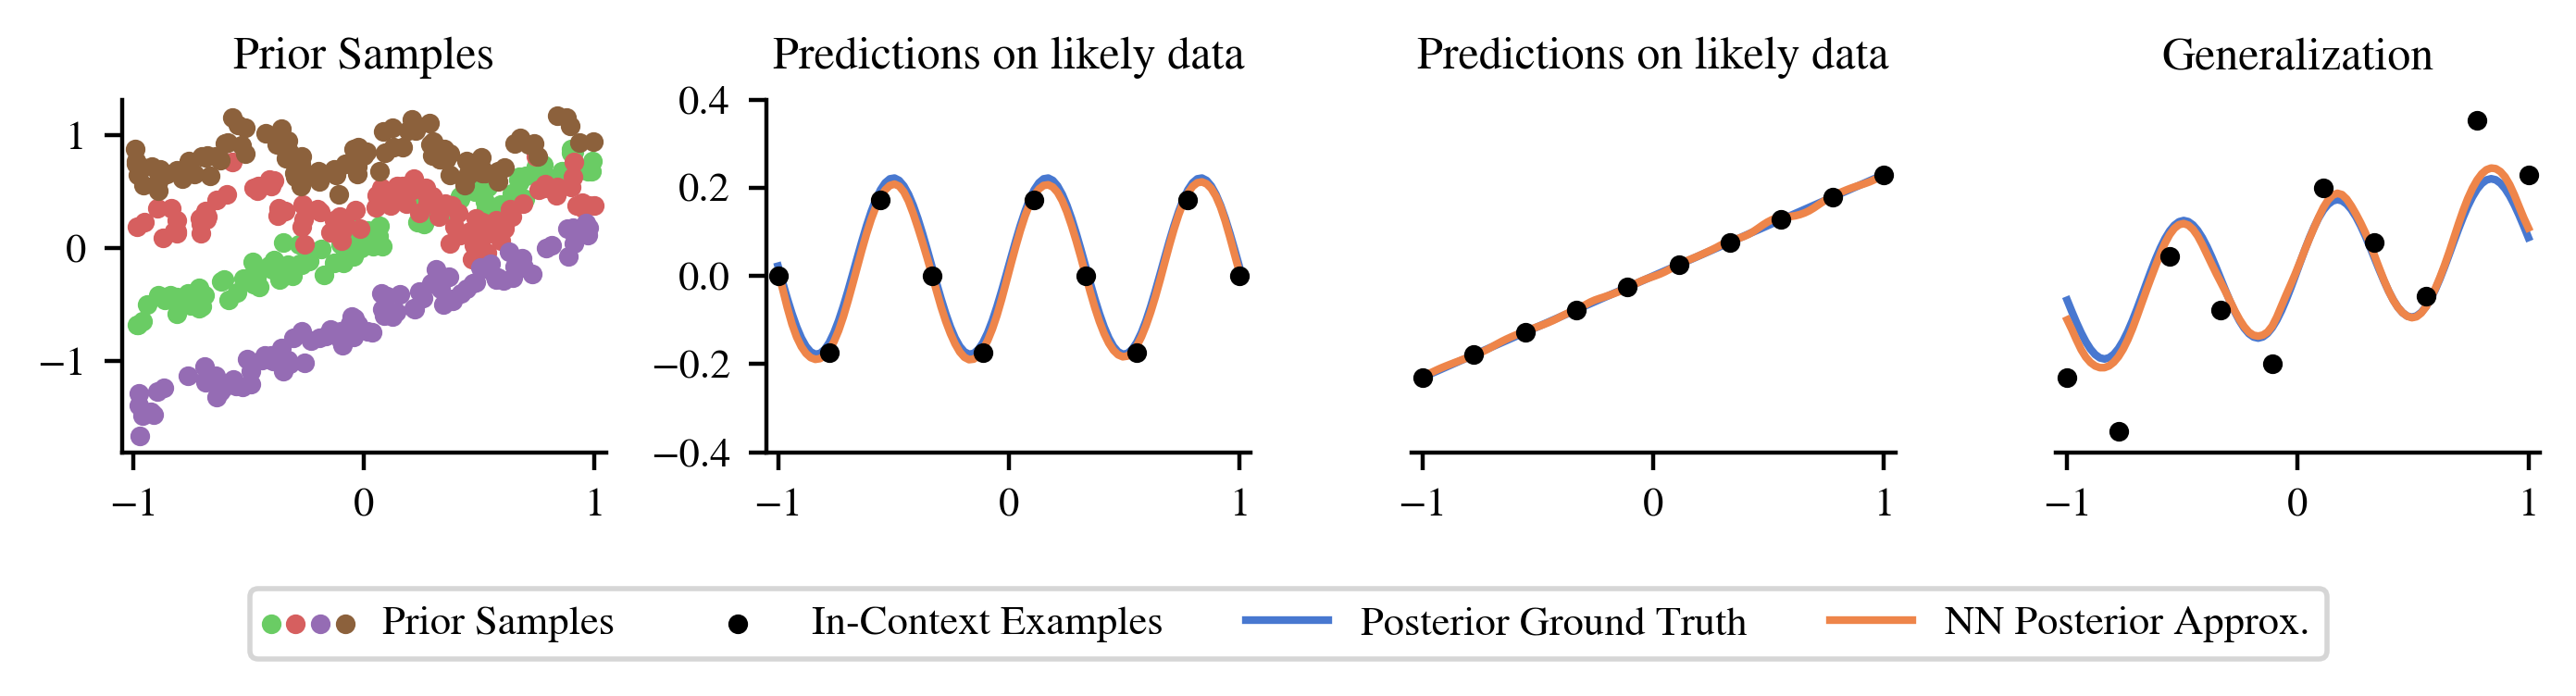

In [59]:
x = torch.linspace(-1, 1, 10)[:, None]
OneDimPlotPanel(
    bae,
    best_sine_and_line_models[0],
    prior_seed=1019,  # has 8 layers
    xy_in_dist_1=(
        x,
        bdb.Sinus(
            torch.tensor([1.0]), amplitudes=amp, frequencies=freq, slopes=0.0
        ).mean_y(x),
    ),
    xy_in_dist_2=(
        x,
        bdb.Sinus(
            torch.tensor([1.0]), amplitudes=0.0, frequencies=freq, slopes=0.23
        ).mean_y(x),
    ),
    xy_generalization=(
        x,
        bdb.Sinus(
            torch.tensor([1.0]), amplitudes=amp, frequencies=freq, slopes=0.23
        ).mean_y(x),
    ),
)(ylim=(-0.4, 0.4), no_ylim_for_sample=True)
plt.savefig("figures/sines_and_lines.pdf", bbox_inches="tight")

0 0
cpu cpu cpu
0 1
cpu cpu cpu
0 2
cpu cpu cpu
0 3
cpu cpu cpu


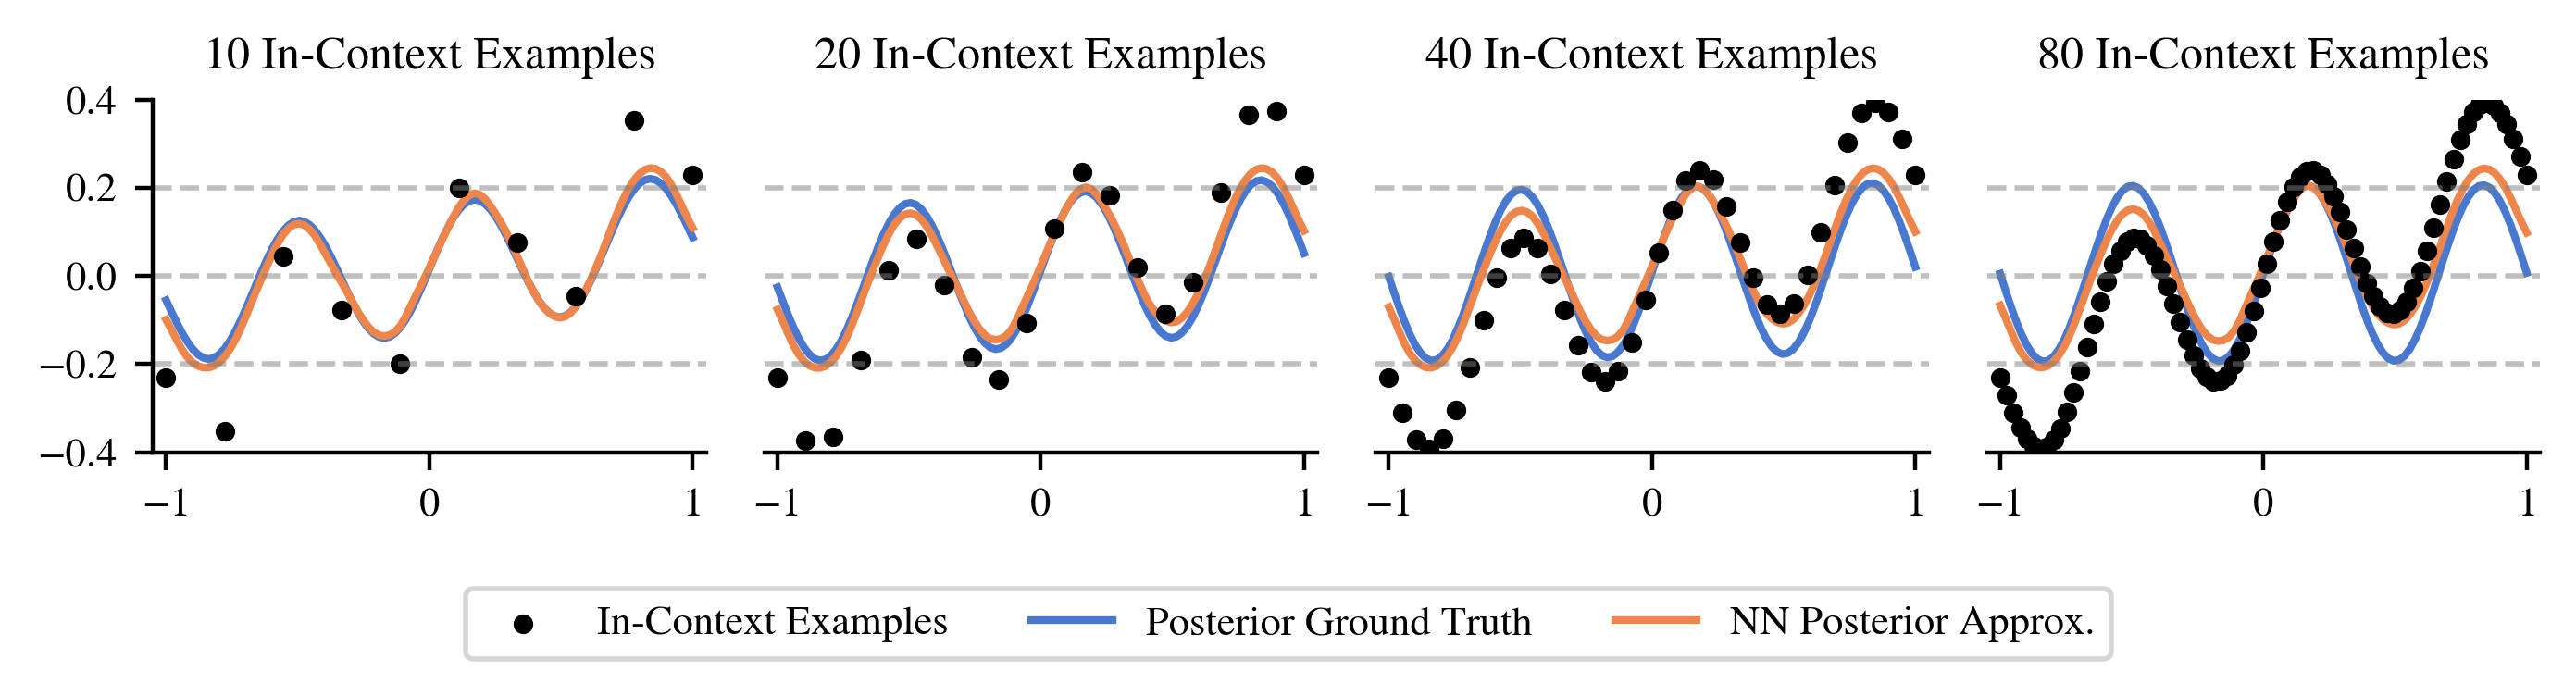

In [60]:
import torch
import matplotlib.pyplot as plt

# Assuming x, y, test_x are already defined in the notebook

width = 7
figsize = (width, width / 4.5)
fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=400)
if len(axs.shape) == 1:
    axs = axs[None, :]
figs = [fig]

for i, n_context_points in enumerate([10, 20, 40, 80]):
    x = torch.linspace(-1, 1, n_context_points)[:, None]
    y = bdb.Sinus(
        torch.tensor([1.0]), amplitudes=amp, frequencies=freq, slopes=0.23
    ).mean_y(x)
    row = i // 4
    col = i % 4
    print(row, col)

    with torch.no_grad():
        handles = plot_data_ground_truth_and_model_predictions(
            axs[row, col], bae, [best_sine_and_line_models[0]], x, y
        )
        axs[row, col].set_title(f"{n_context_points} In-Context Examples")

yticks = [0.2, 0.0, -0.2]

ax_list = axs.flatten()
for i, ax in enumerate(ax_list):
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim((-0.4, 0.4))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    for y in yticks:
        ax.axhline(y=y, color="gray", linestyle="--", linewidth=1.0, alpha=0.5)

for ax_row in axs:
    for ax in ax_row[1:]:
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel("")
        ax.spines["left"].set_visible(False)

# tuples of handles like (p1, p3)).
legend_reordering = [2, 0, 1]
fig.legend(
    [handles[i] for i in legend_reordering if handles[i]],
    [
        ["Posterior Ground Truth", "NN Posterior Approx.", "In-Context Examples"][i]
        for i in legend_reordering
        if handles[i]
    ],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(0.5, 0.0),
    ncols=6,
    loc="upper center",
)

plt.tight_layout()
plt.savefig(
    "figures/bad_priors_become_worse_with_more_conditioning.pdf", bbox_inches="tight"
)
plt.show()

0 0
cpu cpu cpu
0 1
cpu cpu cpu
0 2
cpu cpu cpu
0 3
cpu cpu cpu
1 0
cpu cpu cpu
1 1
cpu cpu cpu
1 2
cpu cpu cpu
1 3
cpu cpu cpu


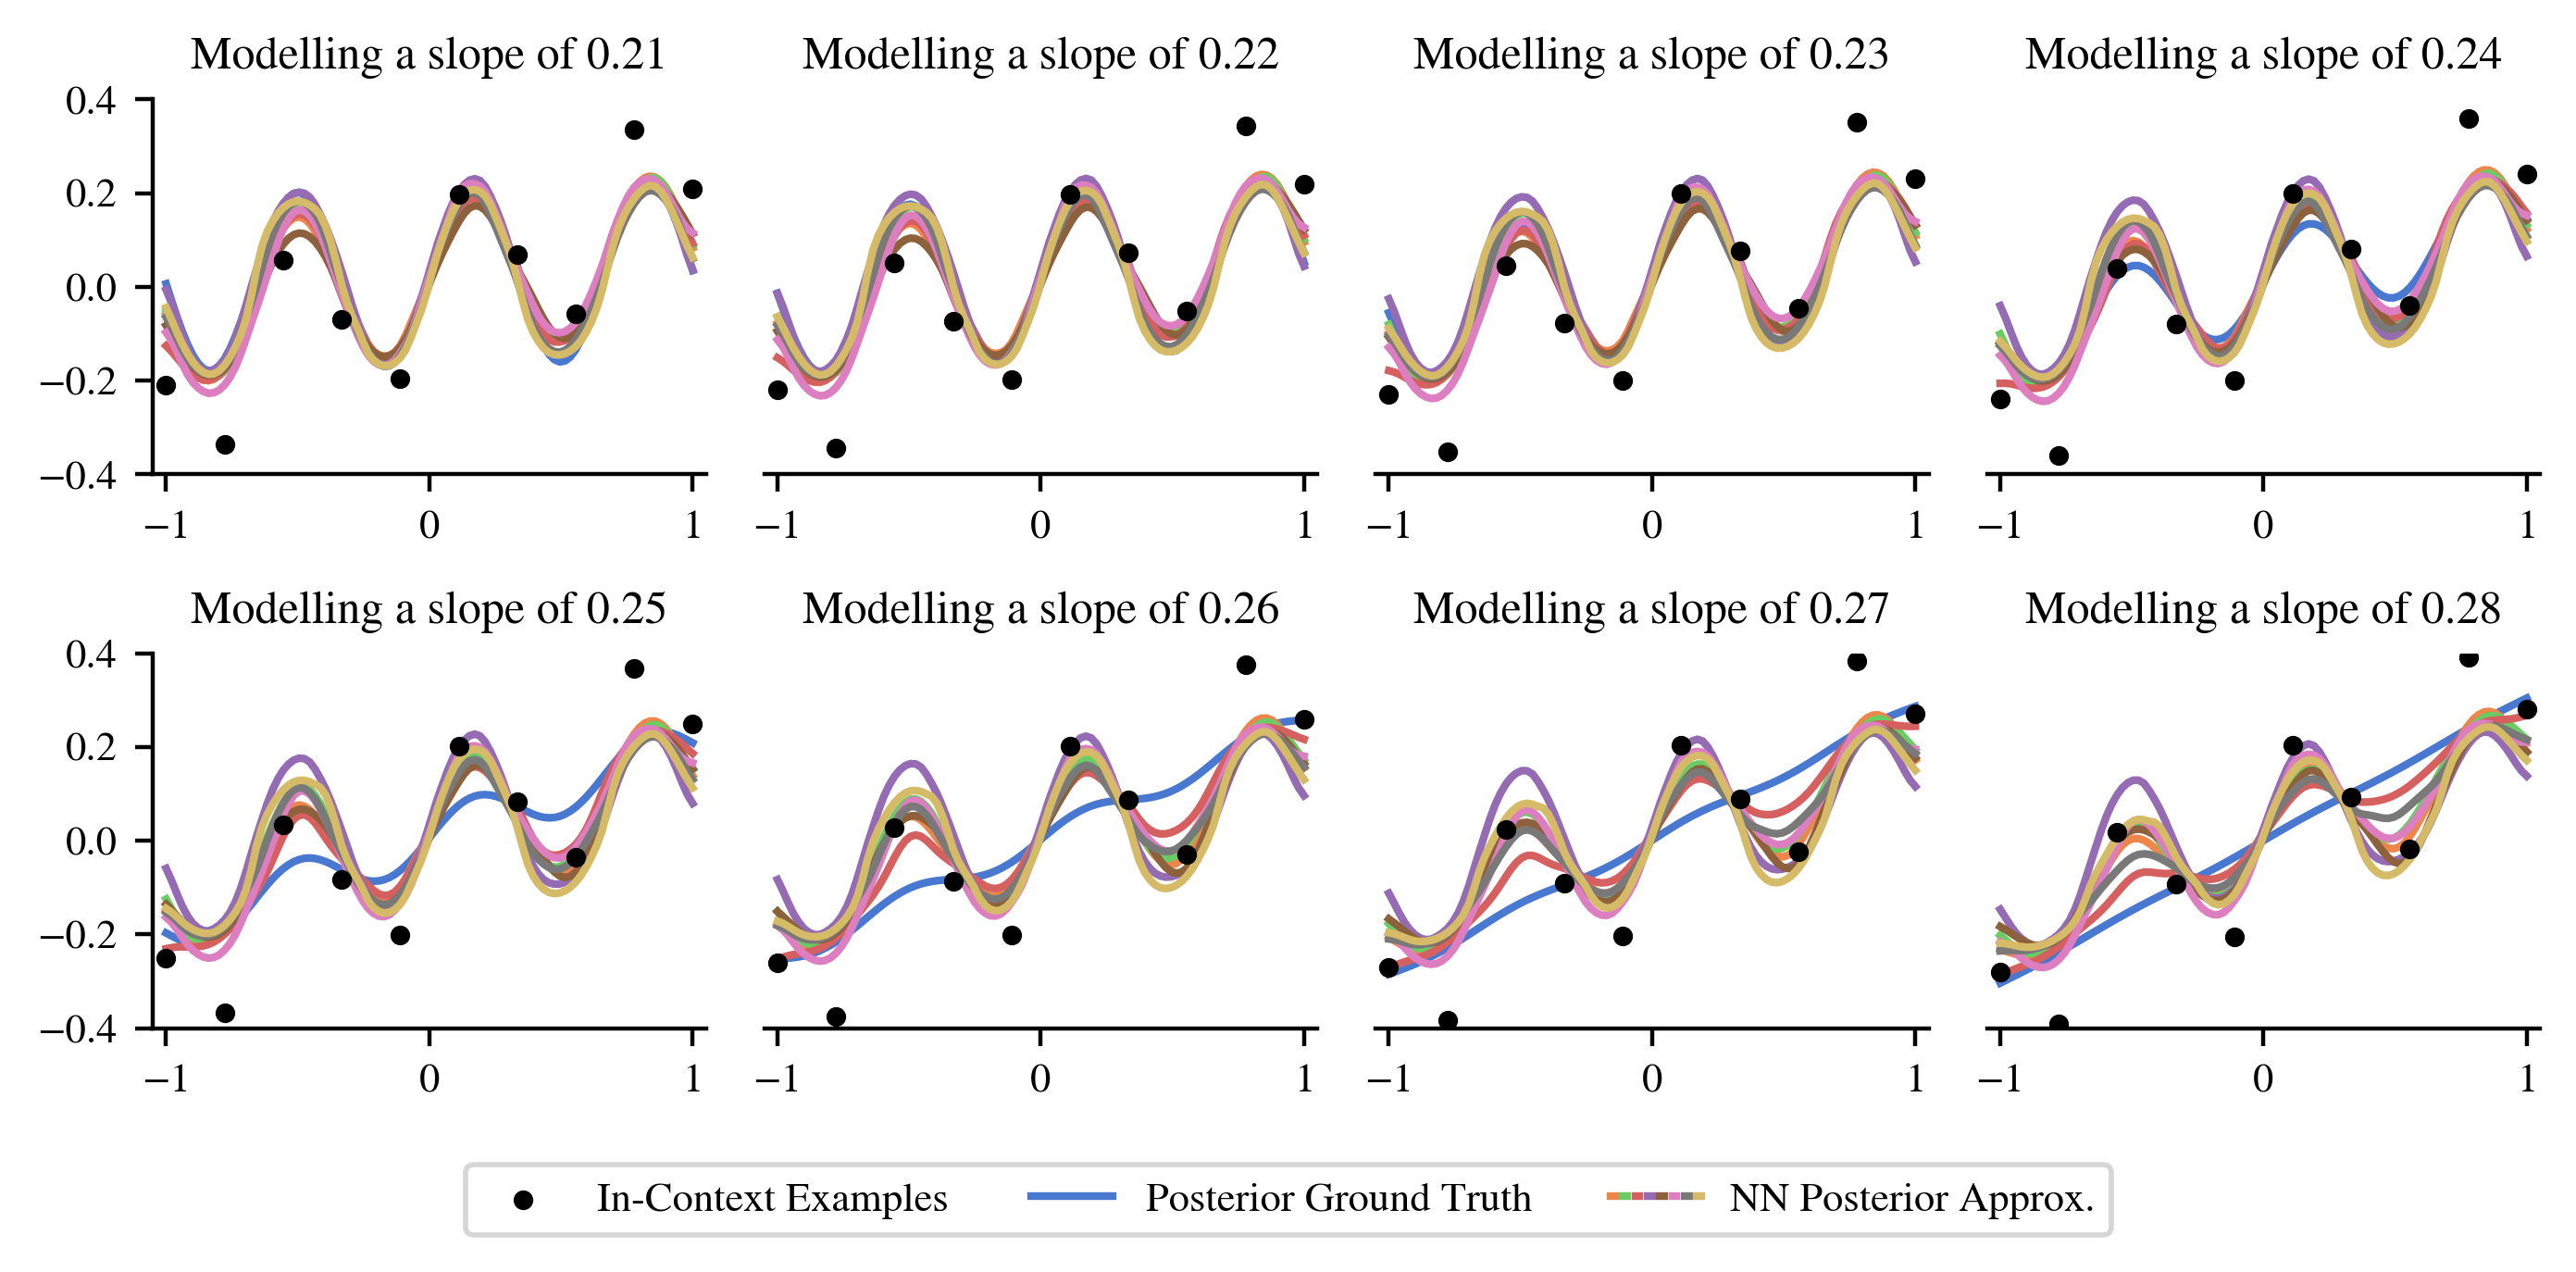

In [61]:
import torch
import matplotlib.pyplot as plt

# Assuming x, y, test_x are already defined in the notebook

width = 7
figsize = (width, 2 * width / 4.5)
fig, axs = plt.subplots(2, 4, figsize=figsize, dpi=400)
figs = [fig]

for i, slope in enumerate([0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28]):
    x = torch.linspace(-1, 1, 10)[:, None]
    y = bdb.Sinus(
        torch.tensor([1.0]), amplitudes=amp, frequencies=freq, slopes=slope
    ).mean_y(x)
    row = i // 4
    col = i % 4
    print(row, col)

    with torch.no_grad():
        handles = plot_data_ground_truth_and_model_predictions(
            axs[row, col], bae, best_sine_and_line_models, x, y
        )
        axs[row, col].set_title(f"Modelling a slope of {slope:.2f}")


ax_list = axs.flatten()
for i, ax in enumerate(ax_list):
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim((-0.4, 0.4))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


for ax_row in axs:
    for ax in ax_row[1:]:
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.spines["left"].set_visible(False)

# tuples of handles like (p1, p3)).
legend_reordering = [2, 0, 1]
fig.legend(
    [handles[i] for i in legend_reordering],
    [
        ["Posterior Ground Truth", "NN Posterior Approx.", "In-Context Examples"][i]
        for i in legend_reordering
    ],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(0.5, 0.0),
    ncols=6,
    loc="upper center",
)

plt.tight_layout()
plt.savefig("figures/sines_and_lines_slope_abl.pdf", bbox_inches="tight")
plt.show()

In [63]:
# Our HPO
# sine_and_line_sin_yoffset_fixed_small_budgets = train_a_pfn(bae.get_batch, lr=lr, batch_size=batch_size, nlayers=nlayers, epochs=epochs,emsize=emsize,max_dataset_size=max_dataset_size)
#      for nlayers in [8] for batch_size in [64] for lr in [.0001,.0003,.001]
#      for emsize in [512] for epochs in [1,2,4,8,16,32,64,128,256] for max_dataset_size in [100]
#     ]
# )

epochs_choices = [1, 2, 4, 8, 16, 32, 64, 128]
model_and_loss_per_epochs = torch.load(
    "models_diff/sine_and_line_sin_yoffset_fixed_small_budgets_best_models_per_epoch.pt"
)

0 0
cpu cpu cpu
0 1
cpu cpu cpu
0 2
cpu cpu cpu
0 3
cpu cpu cpu
1 0
cpu cpu cpu
1 1
cpu cpu cpu
1 2
cpu cpu cpu
1 3
cpu cpu cpu


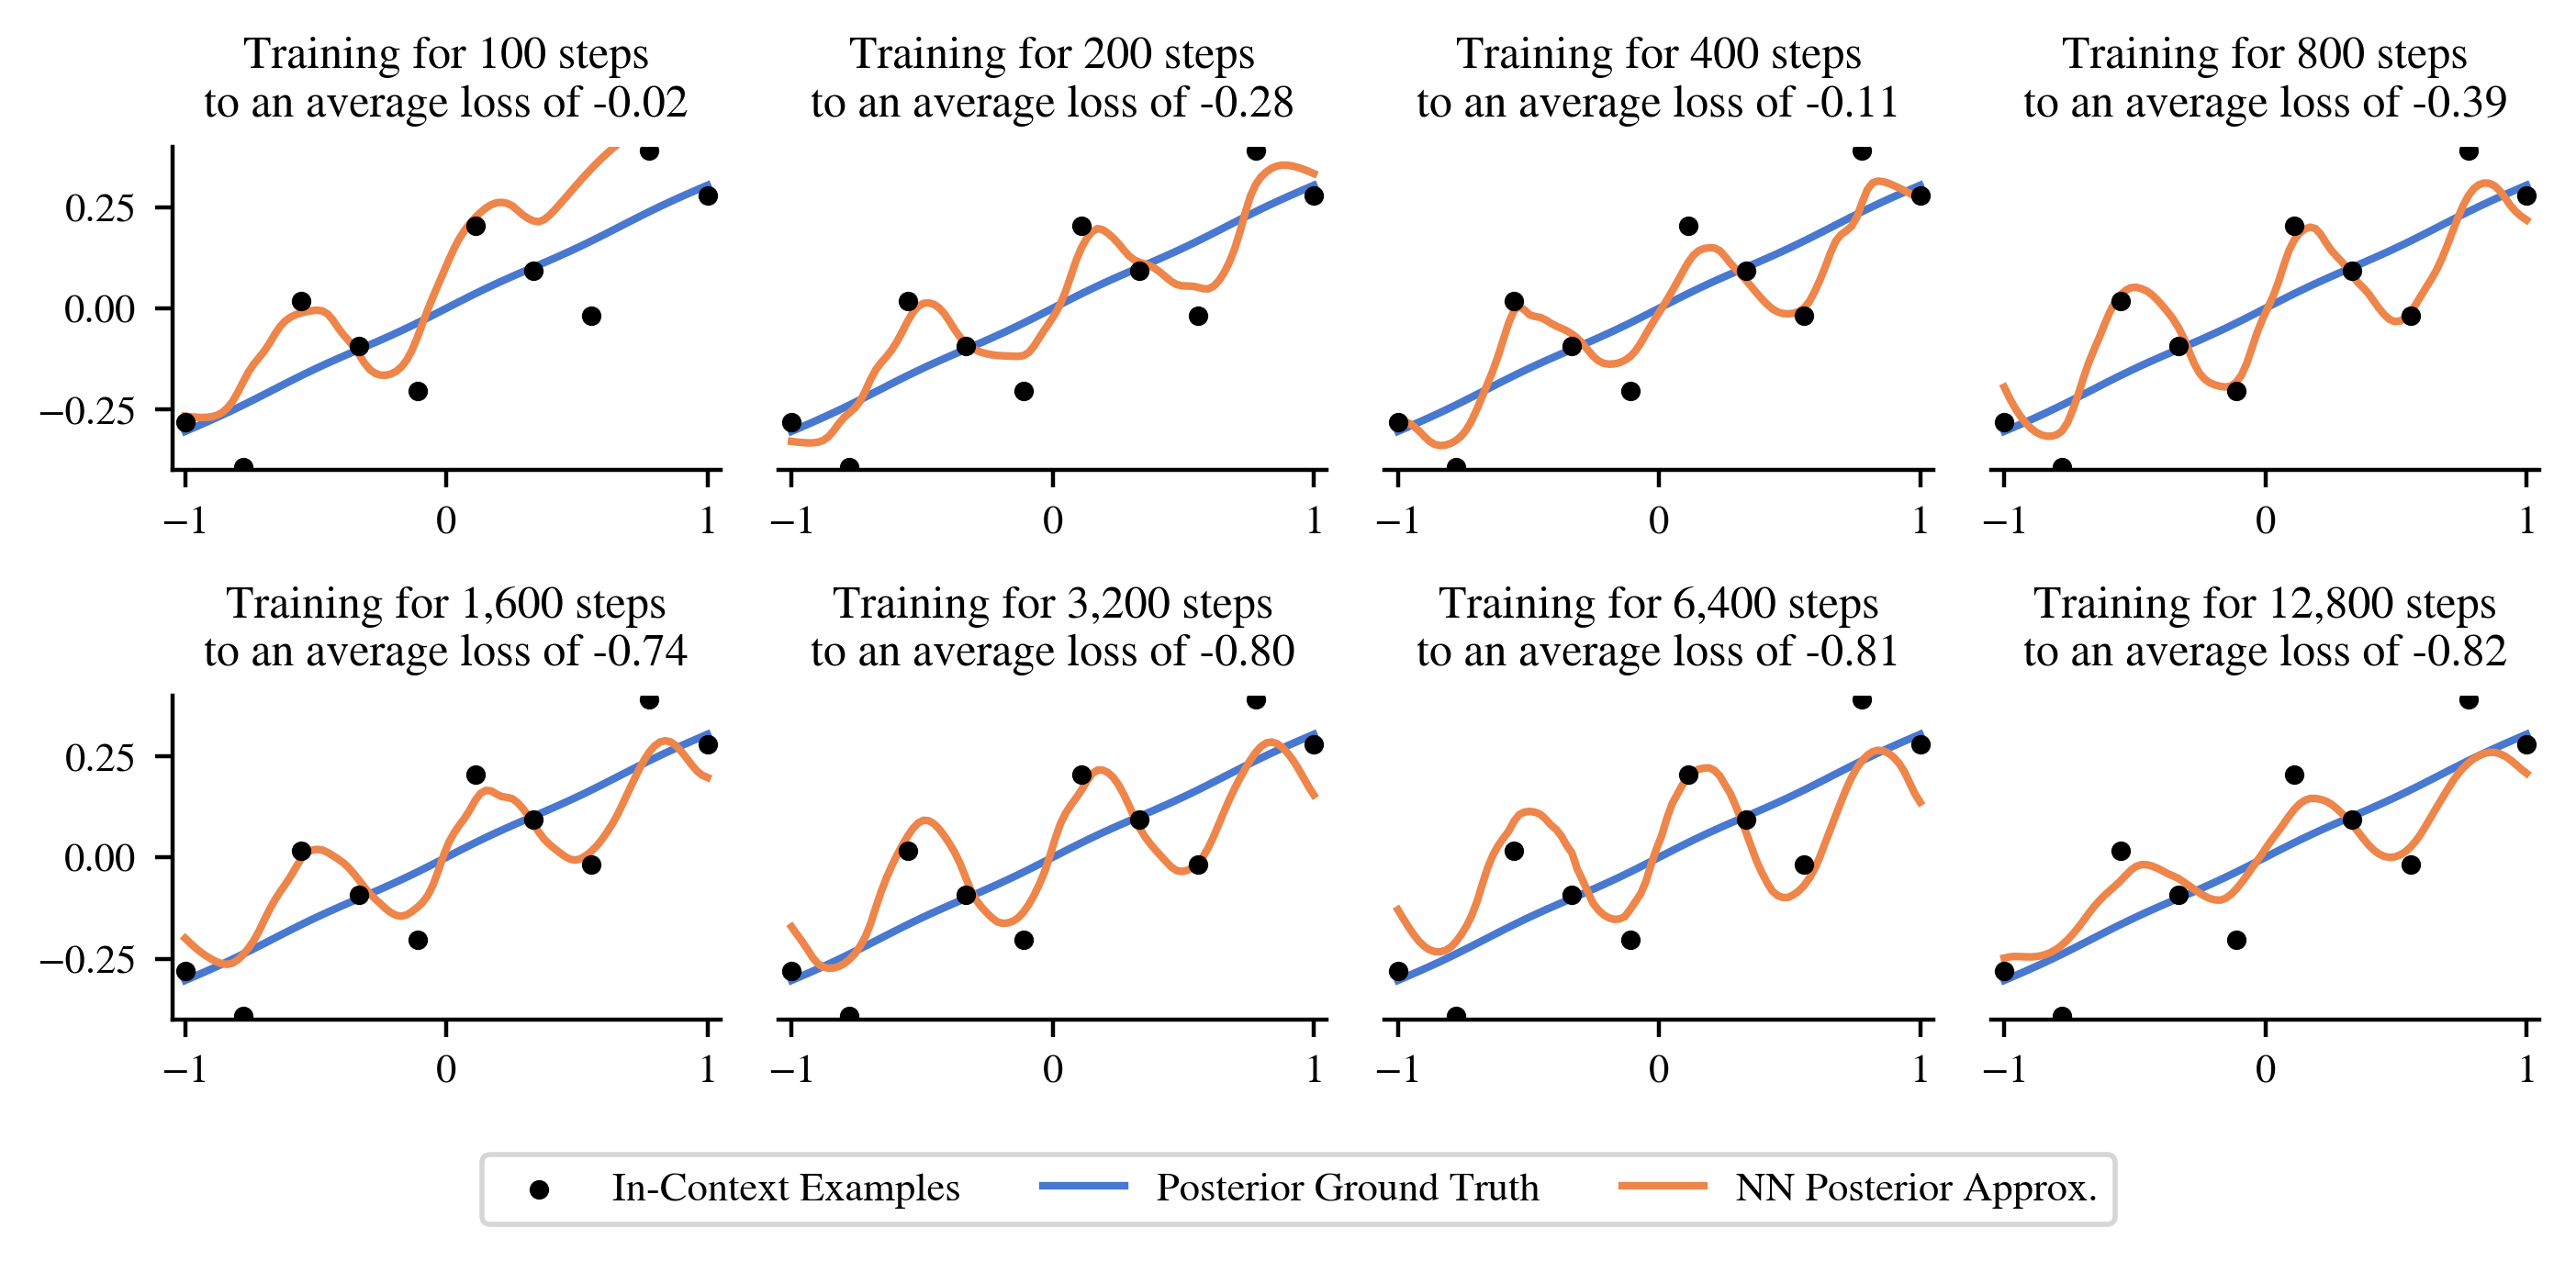

In [64]:
import torch
import matplotlib.pyplot as plt

# Assuming x, y, test_x are already defined in the notebook

width = 7
figsize = (width, 2 * width / 4.5)
fig, axs = plt.subplots(2, 4, figsize=figsize, dpi=400)
figs = [fig]

for i, (epochs, (m, loss)) in enumerate(model_and_loss_per_epochs.items()):
    row = i // 4
    col = i % 4
    print(row, col)
    with torch.no_grad():
        handles = plot_data_ground_truth_and_model_predictions(
            axs[row, col], bae, m, x, y
        )
        axs[row, col].set_title(
            f"Training for {epochs * 100:,} steps\nto an average loss of {loss:.2f}"
        )


ax_list = axs.flatten()
for i, ax in enumerate(ax_list):
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim((-0.4, 0.4))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


for ax_row in axs:
    for ax in ax_row[1:]:
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.spines["left"].set_visible(False)

# tuples of handles like (p1, p3)).
legend_reordering = [2, 0, 1]
fig.legend(
    [handles[i] for i in legend_reordering],
    [
        ["Posterior Ground Truth", "NN Posterior Approx.", "In-Context Examples"][i]
        for i in legend_reordering
    ],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(0.5, 0.0),
    ncols=6,
    loc="upper center",
)

plt.tight_layout()
plt.savefig("figures/sines_and_lines_epoch_abl.pdf", bbox_inches="tight")
plt.show()

## Predicting Sines Teaches To Predict Flat, for unknown frequencies

In [19]:
sins_freq = 3 * torch.pi


bae_sins = bdb.DiscreteBayes(
    [
        bdb.Sinus(
            torch.ones(101),
            x_offsets=torch.linspace(0, 1, 101),
            amplitudes=0.2,
            frequencies=sins_freq,
        )
    ]
)

x = torch.linspace(-1, 1, 2000001)[:, None]
y = bdb.Sinus(torch.tensor([1]), amplitudes=0.2, frequencies=2.0 * torch.pi).mean_y(x)
# y += torch.randn_like(y)*.05

test_x = torch.linspace(-1, 1, 100)[:, None]
pred, posterior, _, _ = bae_sins.posterior_predictive_mean(
    x, y, test_x, verbose_output=True
)

cpu cpu cpu


In [40]:
# Our HPO
# sins_2pifreq = [train_a_pfn(bae_sins.get_batch, lr=lr, batch_size=batch_size, nlayers=nlayers, emsize=emsize, epochs=epochs, max_dataset_size=max_dataset_size)
#     for nlayers in [8] for batch_size in [32,64] for lr in [.0001,.0003,.001]
#     for emsize in [128,256,512] for epochs in [100,200,400] for max_dataset_size in [20]
# ])
sins_model = torch.load("models_diff/sins_2pifreq_model.pt")

/tmp/ipykernel_2743969/484053737.py:76: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles += [ax.scatter(x,y,s=scatter_size,c=palette[i+2])]


cpu cpu cpu
cpu cpu cpu
cpu cpu cpu


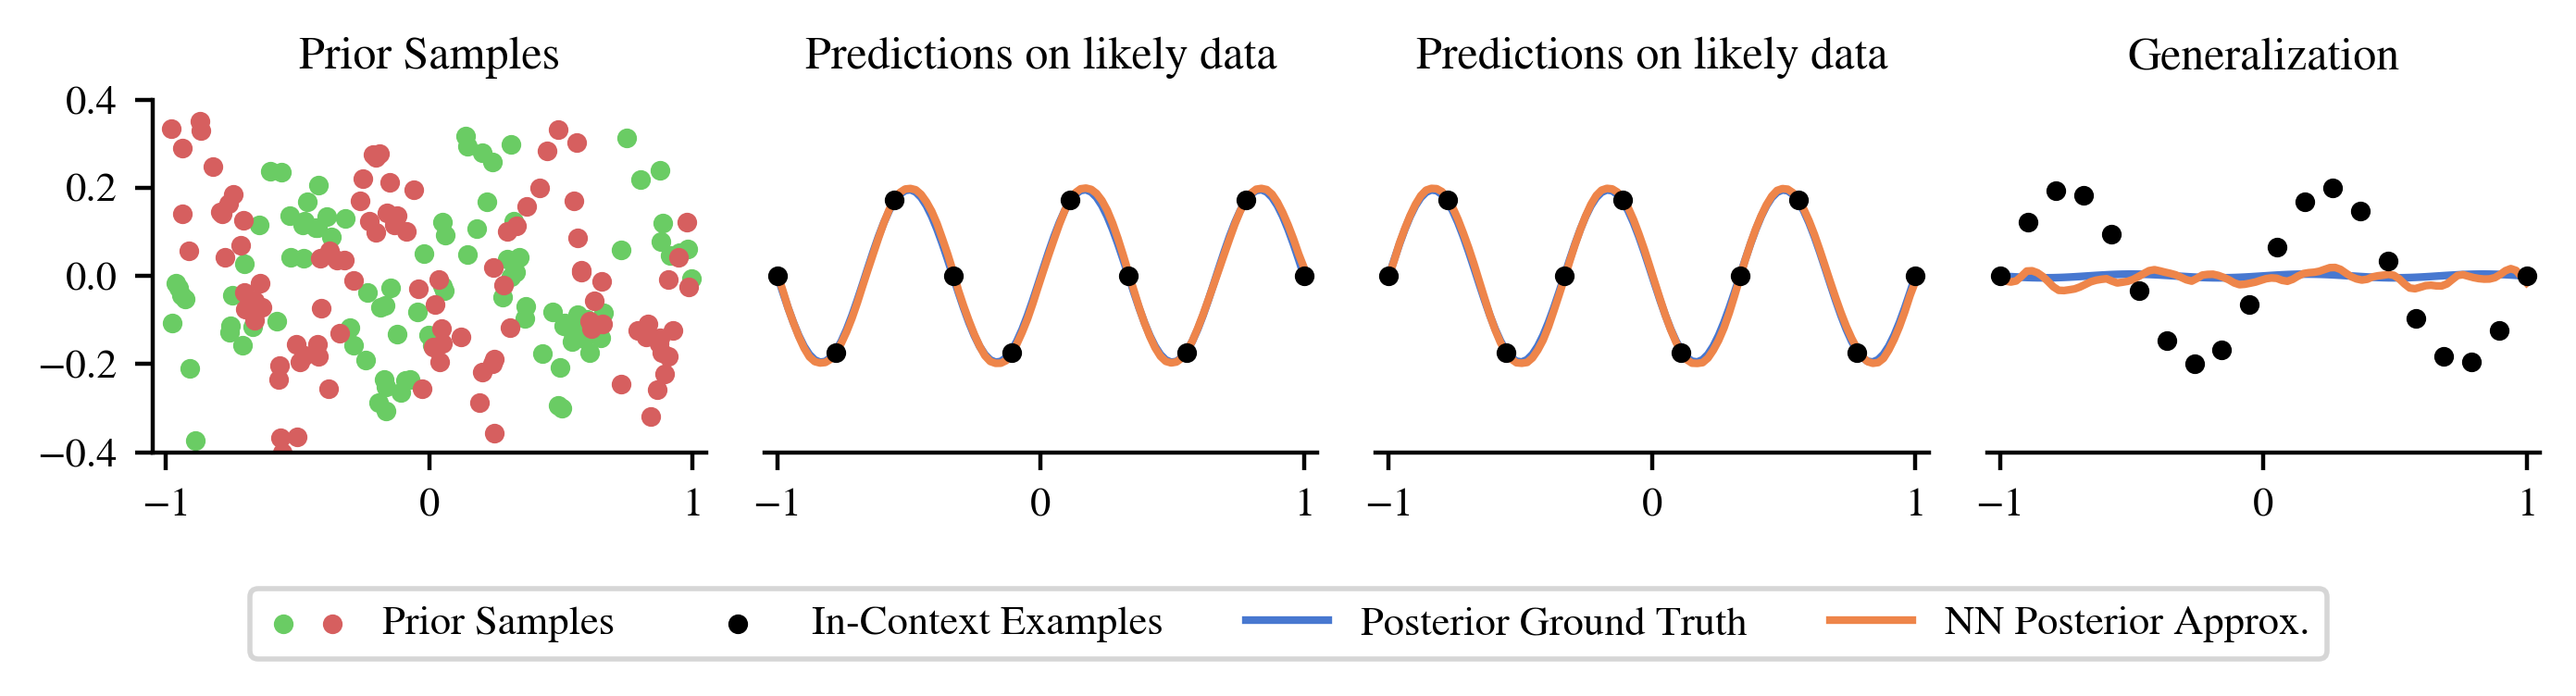

In [22]:
x = torch.linspace(-1, 1, 10)[:, None]
x_gen = torch.linspace(-1, 1, 20)[:, None]
figs = OneDimPlotPanel(
    bae_sins,
    sins_model,
    prior_seed=1,  # has 8 layers
    xy_in_dist_1=(
        x,
        bdb.Sinus(torch.tensor([1.0]), amplitudes=amp, frequencies=freq).mean_y(x),
    ),
    xy_in_dist_2=(
        x,
        bdb.Sinus(
            torch.tensor([1.0]), amplitudes=amp, frequencies=freq, x_offsets=0.5
        ).mean_y(x),
    ),
    xy_generalization=(
        x_gen,
        bdb.Sinus(torch.tensor([1]), amplitudes=0.2, frequencies=2 * torch.pi).mean_y(
            x_gen
        ),
    ),
)(ylim=(-0.4, 0.4), num_prior_examples=2)

# utils.tikzplotlib_save(f'figures/sins.tex', axis_width=r".3\textwidth", axis_height=r".3\textwidth")
# import os
# os.makedirs(f'figures/sins', exist_ok=True)
# for i, fig in enumerate(figs):
#    utils.tikzplotlib_save(f'figures/sins/figure_{i}.tex', figure=fig)
plt.savefig("figures/sins.pdf", bbox_inches="tight")

## Step Functions Generalize to Smooth Function

In [23]:
x_offsets, y_offsets, amplitudes = torch.meshgrid(
    torch.linspace(-1, 1, 101), torch.linspace(-1, 1, 101), torch.linspace(0, 2, 101)
)

bae_steps = bdb.DiscreteBayes(
    [
        bdb.Step(
            torch.ones(x_offsets.numel()),
            noise_std=0.1,
            x_offsets=x_offsets.flatten(),
            y_offsets=y_offsets.flatten(),
            amplitudes=amplitudes.flatten(),
        )
    ]
)

x = torch.linspace(-1, 1, 10)[:, None]
y = x * 0.1

test_x = torch.linspace(-1, 1, 100)[:, None]
pred = bae_steps.posterior_predictive_mean(x, y, test_x)
print("density:", bae.compute_log_posterior(x, y)[-1].exp())

cpu cpu cpu
cpu cpu cpu
density: tensor(1.2040)


In [24]:
# OUR HPO
# steps_noise01 = [train_a_pfn(bae_steps.get_batch, lr=lr, batch_size=batch_size, nlayers=nlayers, emsize=emsize, epochs=epochs, max_dataset_size=max_dataset_size)
#      for nlayers in [4,8] for batch_size in [32,64] for lr in [.0001,.0003,.001]
#      for emsize in [128,256,512] for epochs in [100,200,400] for max_dataset_size in [20,100]])
steps_model = torch.load("models_diff/steps_noise01_model.pt")

/tmp/ipykernel_2743969/484053737.py:76: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles += [ax.scatter(x,y,s=scatter_size,c=palette[i+2])]


cpu cpu cpu
cpu cpu cpu
cpu cpu cpu


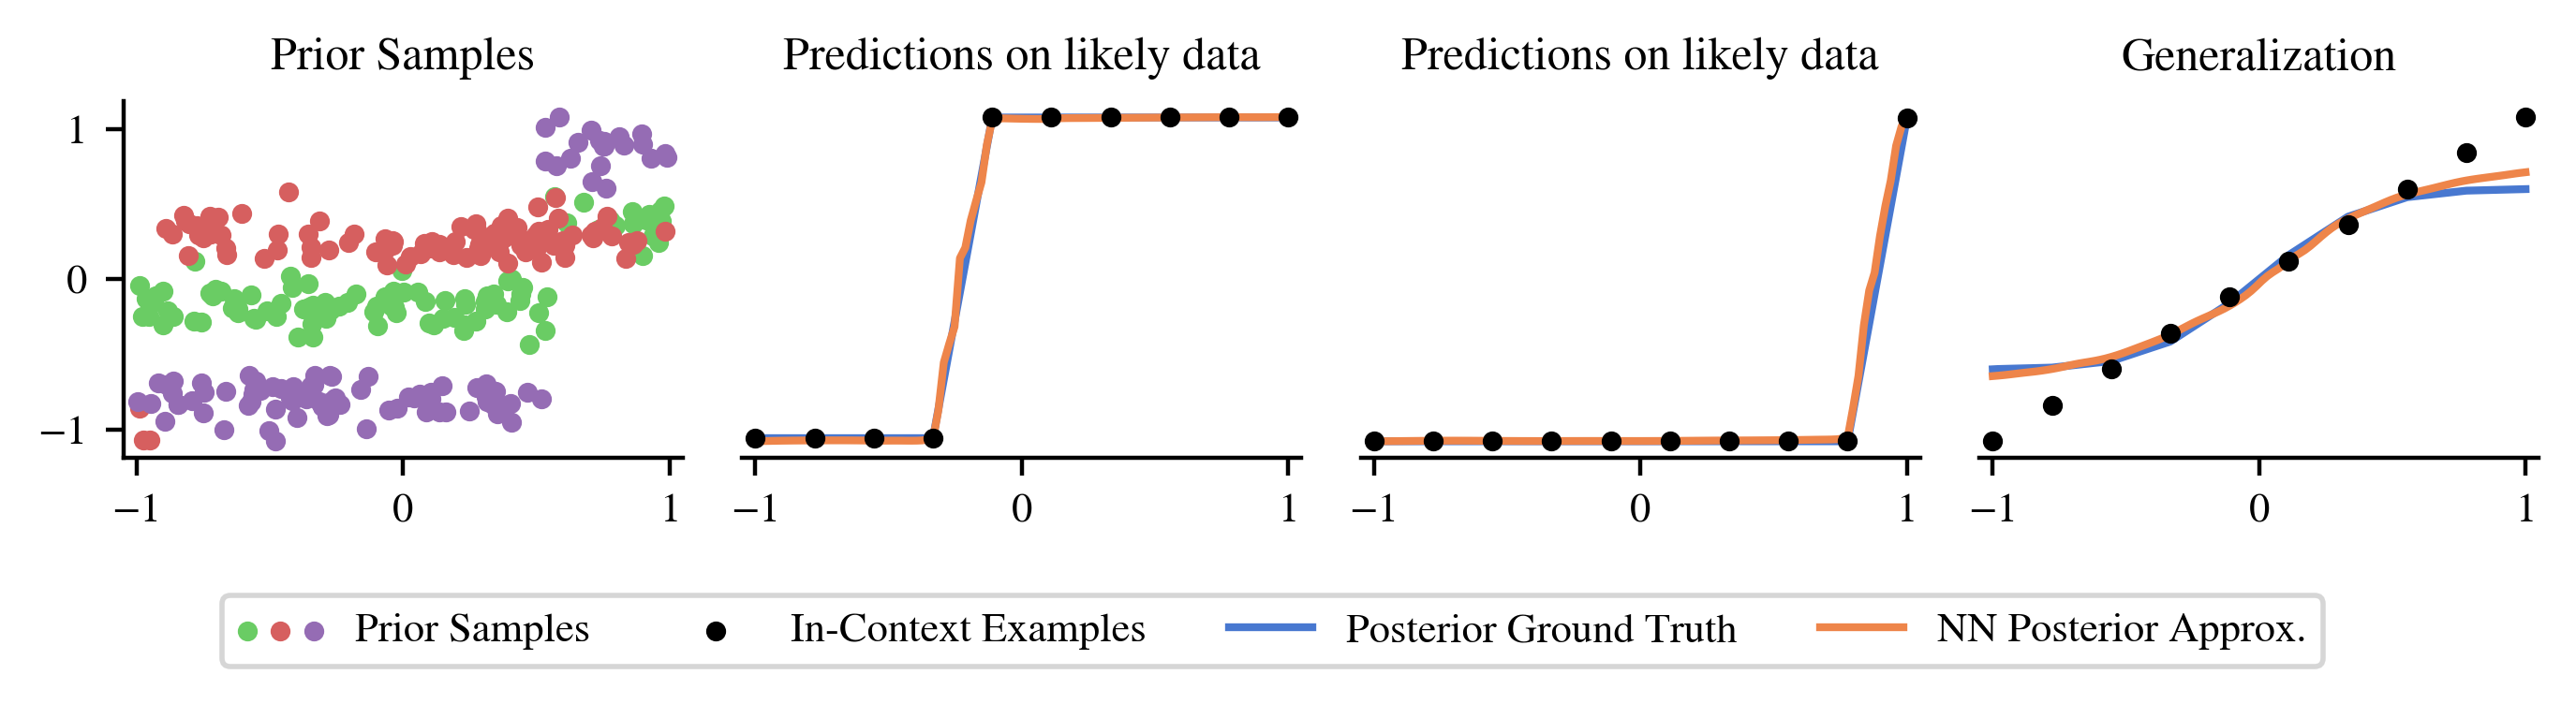

In [25]:
x = torch.linspace(-1, 1, 10)[:, None]
OneDimPlotPanel(
    bae_steps,
    steps_model,
    prior_seed=10,
    xy_in_dist_1=(
        x,
        bdb.Step(
            torch.tensor([1.0]),
            noise_std=0.2,
            x_offsets=-0.2,
            y_offsets=0.0,
            amplitudes=0.5,
        ).mean_y(x),
    ),
    xy_in_dist_2=(
        x,
        bdb.Step(
            torch.tensor([1.0]),
            noise_std=0.2,
            x_offsets=0.8,
            y_offsets=-0.5,
            amplitudes=1.0,
        ).mean_y(x),
    ),
    xy_generalization=(x, x * 0.2),
)(num_prior_examples=3)

plt.savefig("figures/steps.pdf", bbox_inches="tight")

## Stepping Up and Down: Being Representable is not Enough

In [26]:
x_offsets, y_offsets, amplitudes = torch.meshgrid(
    torch.linspace(-1, 1, 201), torch.linspace(-1, 1, 201), torch.linspace(-1, 1, 201)
)

step_up_down_prior = bdb.Step(
    torch.ones(x_offsets.numel()),
    noise_std=0.1,
    x_offsets=x_offsets.flatten(),
    y_offsets=y_offsets.flatten(),
    amplitudes=amplitudes.flatten(),
)
bae_steps_up_down = bdb.DiscreteBayes([step_up_down_prior])

x = torch.linspace(-1, 1, 20)[:, None]
height = 0.2
y = (0.0 + (x > -0.5).float() - (x > 0.5).float()) * height

test_x = torch.linspace(-1, 1, 100)[:, None]
pred, posterior, _, _ = bae_steps_up_down.posterior_predictive_mean(
    x, y, test_x, verbose_output=True
)
print("density:", bae_steps_up_down.compute_log_posterior(x, y)[-1].exp())

cpu cpu cpu
cpu cpu cpu
density: tensor(0.5735)


In [27]:
# Our HPO
# steps_up_down = [train_a_pfn(bae_steps_up_down.get_batch, lr=lr, batch_size=batch_size, nlayers=nlayers, emsize=emsize, epochs=epochs, max_dataset_size=max_dataset_size)
#      for nlayers in [4,8] for batch_size in [32,64] for lr in [.0001,.0003,.001]
#      for emsize in [128,256,512] for epochs in [100,200,400] for max_dataset_size in [20,100]])

steps_up_down_model = torch.load("models_diff/steps_up_down_model.pt")

cpu cpu cpu


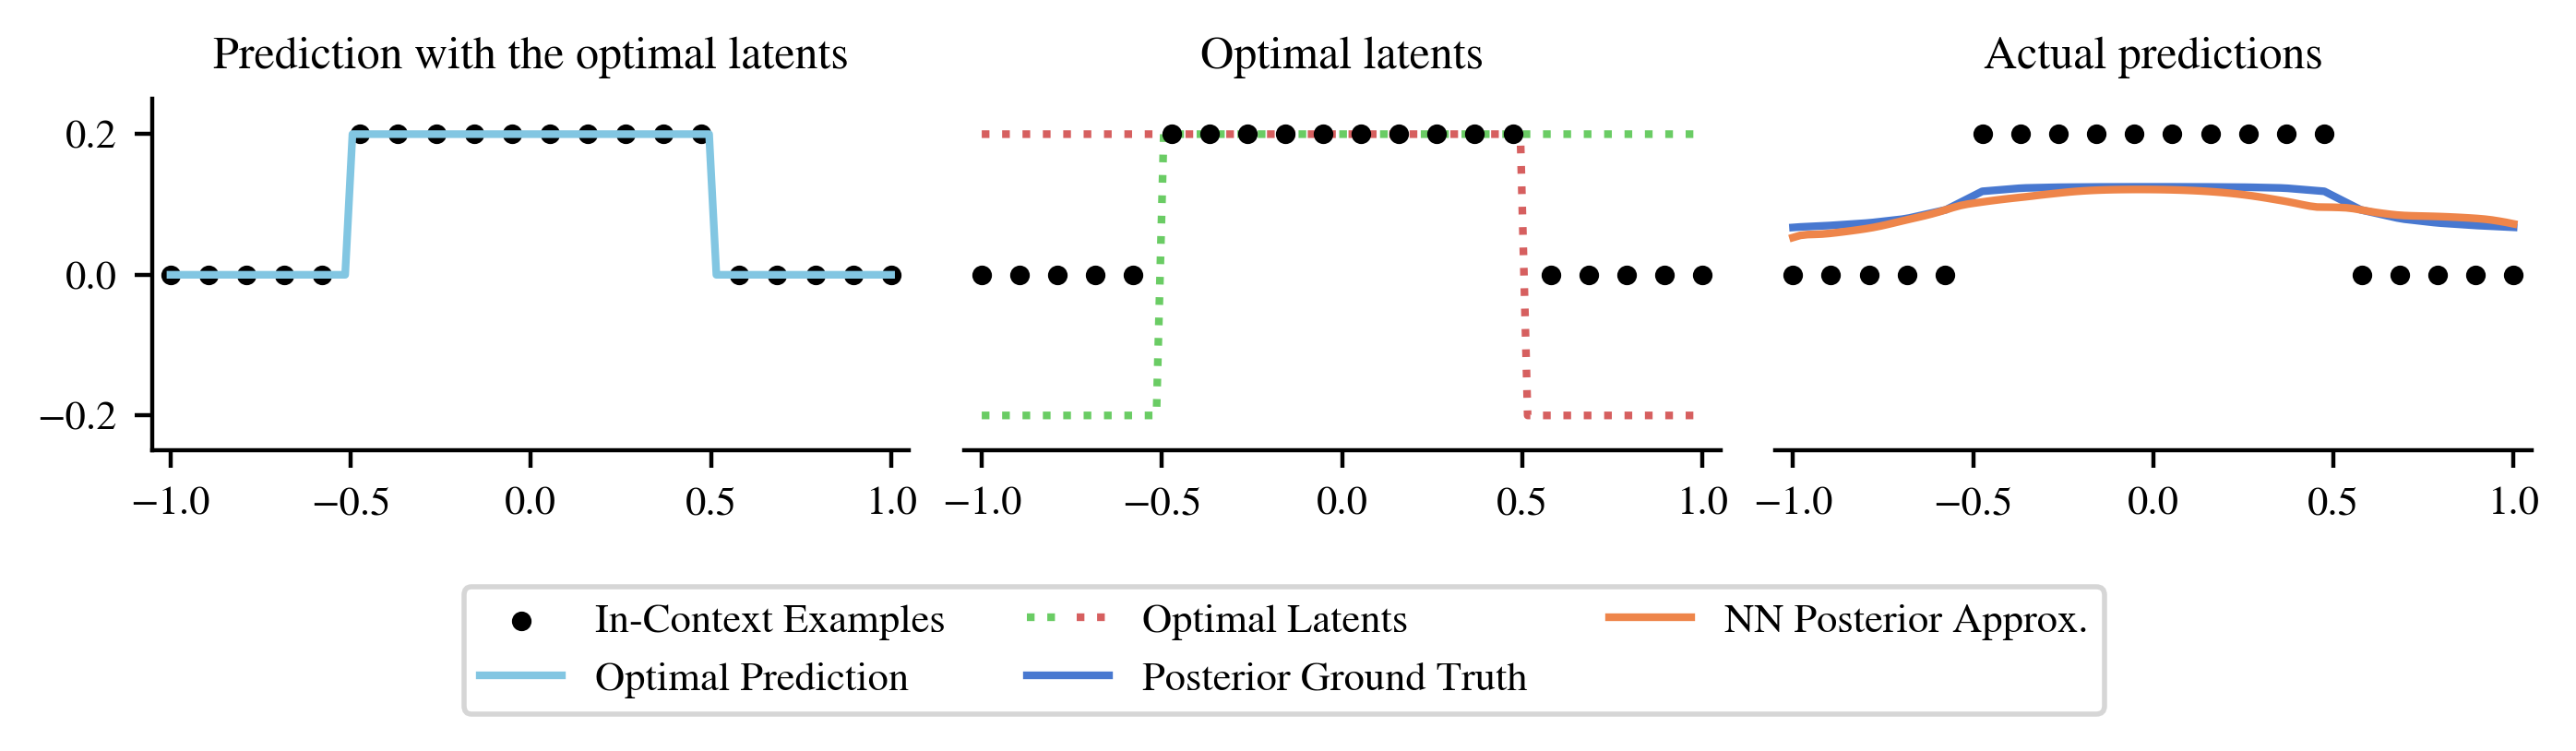

In [29]:
import torch
import matplotlib.pyplot as plt

# Assuming job_per_epochs, x, y, test_x are already defined in the notebook

width = 7
rows = 1
figsize = (width, rows * width / 4.5)
fig, axs = plt.subplots(rows, 3, figsize=figsize, dpi=400)
# figs = [fig]
handles = []

test_x = torch.linspace(-1, 1, 100)[:, None]

mean_y1 = -height + (test_x > -0.5).float() * 2 * height
mean_y2 = height + (test_x > 0.5).float() * -2 * height

# axs[0].plot(test_x,pred,linewidth=line_size)[0]


# plt.scatter(x,y, c='black')
axs[0].scatter(x, y, s=scatter_size, c="black", zorder=2)
handles.append(
    axs[0].plot(test_x, (mean_y1 + mean_y2) / 2, linewidth=line_size, c=palette[-1])[0]
)
axs[0].set_title("Prediction with the optimal latents")

# handles += [ax.scatter(x,y,s=scatter_size,c='black',zorder=2)]
handles.append(
    (
        axs[1].plot(test_x, mean_y1, linestyle=":", linewidth=line_size, c=palette[2])[
            0
        ],
        axs[1].plot(test_x, mean_y2, linestyle=":", linewidth=line_size, c=palette[3])[
            0
        ],
    )
)
axs[1].scatter(x, y, s=scatter_size, c="black", zorder=2)
axs[1].set_title("Optimal latents")

handles += plot_data_ground_truth_and_model_predictions(
    axs[2], bae_steps_up_down, steps_up_down_model, x, y
)
axs[2].set_title("Actual predictions")

posterior_values, posterior_inds = posterior[0].exp().topk(100)
means_of_posteriors = step_up_down_prior.mean_y(test_x, posterior_inds)


ax_list = axs.flatten()
for i, ax in enumerate(ax_list):
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim((-0.25, 0.25))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


for ax in axs[1:]:
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.spines["left"].set_visible(False)

legend_reordering = [4, 0, 1, 2, 3]

# tuples of handles like (p1, p3)).
fig.legend(
    [handles[i] for i in legend_reordering],
    [
        [
            "Optimal Prediction",
            "Optimal Latents",
            "Posterior Ground Truth",
            "NN Posterior Approx.",
            "In-Context Examples",
        ][i]
        for i in legend_reordering
    ],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(0.5, 0.0),
    ncols=3,
    loc="upper center",
    alignment="center",
)

plt.tight_layout()
plt.savefig(
    "figures/steps_up_down_representation_is_not_enough.pdf", bbox_inches="tight"
)
plt.show()

cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu


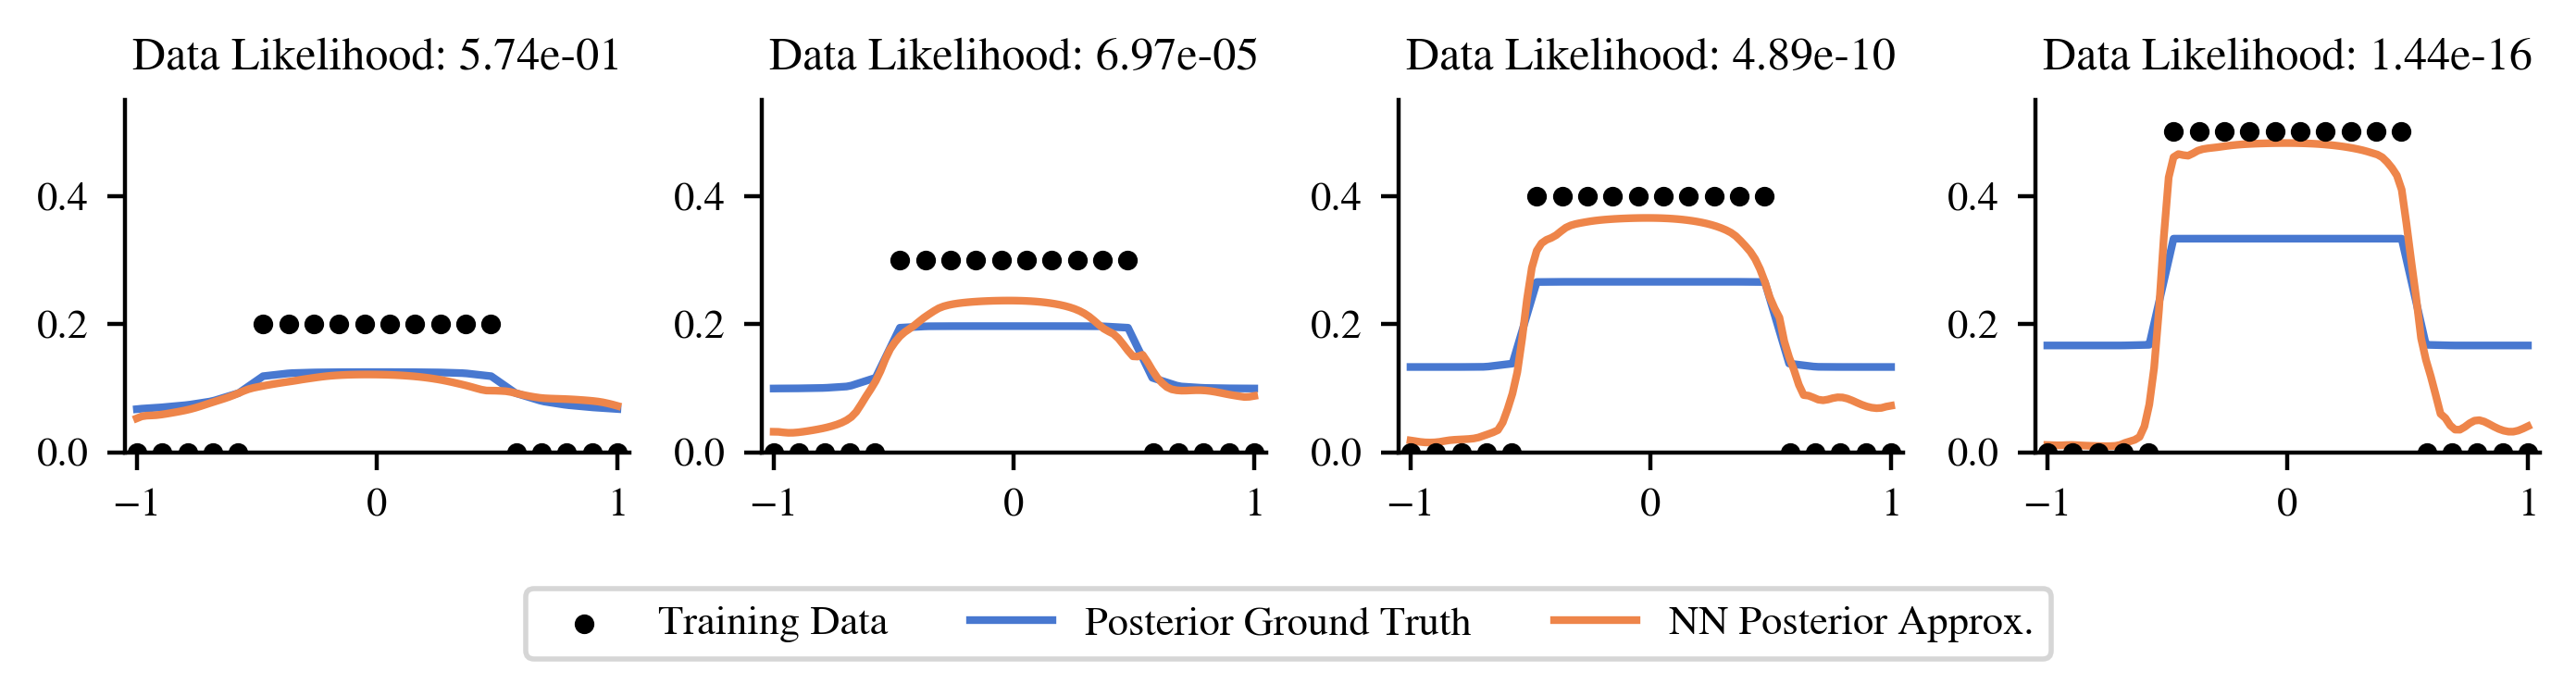

In [31]:
import torch
import matplotlib.pyplot as plt

# Assuming job_per_epochs, x, y, test_x are already defined in the notebook

heights = [0.2, 0.3, 0.4, 0.5]

width = 7
rows = 1
figsize = (width, rows * width / 4.5)
fig, axs = plt.subplots(rows, 4, figsize=figsize, dpi=400)
if len(axs.shape) == 1:
    axs = axs[None]
figs = [fig]

for i, height in enumerate(heights):
    row = i // 4
    col = i % 4

    x = torch.linspace(-1, 1, 20)[:, None]
    y = (0.0 + (x > -0.5).float() - (x > 0.5).float()) * height
    density = bae_steps_up_down.compute_log_posterior(x, y)[-1].exp()

    handles = plot_data_ground_truth_and_model_predictions(
        axs[row, col], bae_steps_up_down, steps_up_down_model, x, y
    )
    axs[row, col].set_title(f"Data Likelihood: {density:.2e}")

ax_list = axs.flatten()
for i, ax in enumerate(ax_list):
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim((0.0, 0.55))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


for ax_row in axs:
    for ax in ax_row[1:]:
        # ax.set_yticks([])
        ax.set_ylabel("")
        # ax.spines['left'].set_visible(False)

# tuples of handles like (p1, p3)).
legend_reordering = [2, 0, 1]
fig.legend(
    [handles[i] for i in legend_reordering],
    [
        ["Posterior Ground Truth", "NN Posterior Approx.", "Training Data"][i]
        for i in legend_reordering
    ],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(0.5, 0.0),
    ncols=6,
    loc="upper center",
)

plt.tight_layout()
# plt.savefig(f'figures/less_likely_data_ablation.pdf', bbox_inches='tight')
plt.show()

## Counting Is Not Possible

In [34]:
from pfns.priors import batched_discrete_bayes as bdb

bae_count = bdb.DiscreteBayes([bdb.Counting(torch.ones(101))])

In [2196]:
# HPO
# counting = [train_a_pfn(bae_count.get_batch, lr=lr, batch_size=batch_size, nlayers=nlayers, epochs=epochs,emsize=emsize,max_dataset_size=max_dataset_size, n_classes=2,)
#      for nlayers in [8] for batch_size in [32,64] for lr in [.0001,.0003,.001]
#      for emsize in [128,256,512] for epochs in [100,200,400] for max_dataset_size in [20,100]
#     ]
# )
counting_model = torch.load("models_diff/counting_model.pt")

In [38]:
one_probs = []
counts = [1, 2, 4, 8, 16, 32, 64]
for count in counts:
    preds, probs, _, _ = bae_count.posterior_predictive_mean(
        torch.zeros(count, 1), torch.ones(count), torch.zeros(1, 1), verbose_output=True
    )

    pred_pred = (
        counting_model(torch.zeros(count, 1), torch.ones(count), torch.zeros(1, 1))
        .softmax(-1)
        .squeeze(0)[1]
        .item()
    )

    one_probs += [(preds[0, 1].item(), pred_pred)]

cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu
cpu cpu cpu


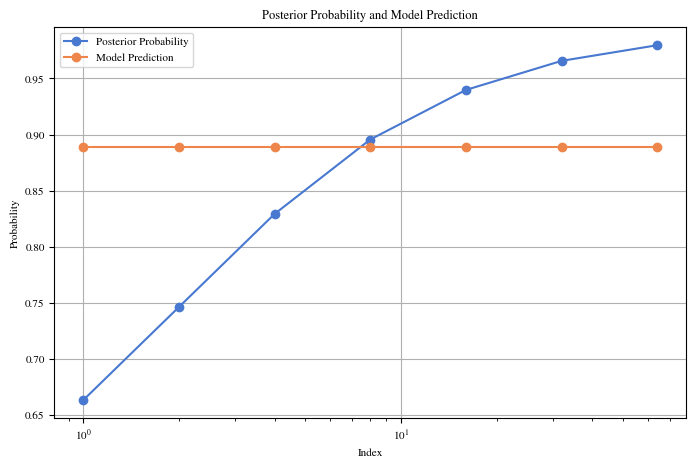

In [39]:
import matplotlib.pyplot as plt

# Assuming one_probs is a list of tuples, we need to unpack them into two separate lists for plotting.
probs, pred_preds = zip(*one_probs)

plt.figure(figsize=(width, width / 1.5))
plt.plot(counts, probs, linewidth=line_size, marker="o", label="Posterior Probability")
plt.plot(counts, pred_preds, linewidth=line_size, marker="o", label="Model Prediction")
plt.xlabel("Index")
plt.ylabel("Probability")
plt.title("Posterior Probability and Model Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xscale("log")
# utils.tikzplotlib_save(f'figures/counting_example.tex', axis_width=r".8\textwidth", axis_height=r".8\textwidth")